In [1]:
import numpy as np
import scipy.stats as sct
import matplotlib.pyplot as plt

In [2]:
x = np.loadtxt("EMGaussian.data")
xtest = np.loadtxt("EMGaussian.test")

On copie les fonctions EM et kmeans du dernier DM car nous en auront besoin.

In [3]:
#La fonction kmeans:
def kmeans(x, k):
    n, p = x.shape
    
    init = np.random.randint(0,n, size=k) #Séléction aléatoire des points de départ
    moyennes = x[init][0:]
    
    
    distortion = 0
    distortions = []
    newdistortion = 10


    while abs(distortion - newdistortion) > 1e-10: #On s'arrête quand la distorsion n'évolue plus assez
        newdistortion = distortion

        
        
        matrice = np.repeat(x, k, axis = 0) #On répète k fois x
        matricemoyennes = np.tile(moyennes, (n,1)) #On répète chaque moyenne k fois
        
        m = matrice - matricemoyennes #on calcule x_{i} - mu_{k}
        m = np.linalg.norm(m, axis=1).reshape(n*k,1)#On calcule la norme de x - mu
        #L'intérêt de calculer les normes de x_{i}-mu_{k} de cette manière
        #est d'éviter les boucles for et donc de perdre temps de calcul.
        
        classes = []
        for i in range(0, n*k, k):
        #On assigne à x_{i} la classe associée au mu_{k} qui lui est le plus proche
            classes.append(np.argmin(m[i:i+k])) 
        
        classes = np.array(classes)
        for i in range(k):
            moyennes[i] = np.mean(x[classes == i], axis=0) #On met à jour les mu_{k} à l'aide des classes trouvées
        
        
        
        #On calcule la nouvelle distortion
        distortion = newdistortion 
        distortion = 0
        distortion = sum([np.sum(np.linalg.norm(x[classes == i] - moyennes[i], axis=1)) for i in range(k)])

        distortions.append(distortion)

    

    return moyennes, classes

In [4]:
#La fonction EM:
def EM(x):
    n, p = x.shape
    #On initialise l'EM à partir des résultats des K-means
    moyennes, classes = kmeans(x,k)

    
    pi = np.array([sum(classes == i)/n for i in range(k)])#On initialise les pi
    
    #On intialise les variances
    variances = [np.cov(x[np.array(classes) == i,0], x[np.array(classes) == i,1]) for i in range(k)]
    
    #On calculera la log-vraissemblance à chaque itération
    v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))
    v2=0


    while abs(v1-v2) > 1e-2: #On s'arrête quand la vraissemblance n'évolue plus assez
        v2 = v1
        
        #On calcul les proba conditionnelles que x_{i} soit dans une classe, sachant les paramètres actuels
        t = np.zeros((n,k))
        for j in range(k):
            t[0:, j] = pi[j]*sct.multivariate_normal.pdf(x, moyennes[j], variances[j])
        sommet = np.sum(t, axis=1).reshape(n,1)
        t = t/sommet

        #On met à jour les pi
        pi = np.sum(t, axis=0)/n
        
        #On met les moyennes à jour
        moyennes = np.array([np.sum(x*t[0:,j].reshape(n,1)/(n*pi[j]), axis=0) for j in range(k)])


        #On met les variances à jour
        for j in range(k):
            variances[j] = np.zeros((2,2))
            for i in range(n):
                variances[j] += t[i,j]*np.dot((x[i] - moyennes[j]).reshape(2,1), (x[i] - moyennes[j]).reshape(1,2))
            variances[j] /= n*pi[j]

        v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))
    
    return moyennes, variances

In [5]:
k=4
mu, sigma = EM(x)
pi = 1/k*np.ones(k)
A = 1/6*np.ones((k,k)) + 1/3*np.eye(k)

#Les algorithmes ont été pensés de manière à ce qu'ils soient robustes à des probabilités nulles

### Question 1: recursions $\alpha$ et $\beta$, et calcul de probabilités

In [6]:
#x: Données d'entrée
#A: Matrice de transition de la chaîne de Markov q
#pi: Distribution initale de la chaîne de Markov q
#mu: Moyennes des lois d'émission (gaussiennes)
#sigma: Matrices de dispersion des lois d'émission(gaussiennes)
#t = 500 signifie que par défaut au calcul tous les alpha_t jusqu'à T=500

#Sortie: Matrice T*k avec T=500 et k = 4, la ligne t est log(alpha_t)L'algorithme a été pensé de manière à ce qu'il soit robuste à des probabilités nulles pour qt=0 à qt = 3
#On calcule les log pour éviter des erreurs numériques

#recursion Alpha:
def alpha(x, pi, A, mu, sigma, t=500):
    alpha = np.ones((x.shape[0], k))
    
    for j in range(k):
        e = sct.multivariate_normal.pdf(x[0], mu[j], sigma[j])
        if pi[j]!=0 and e!=0:
            alpha[0, j] = np.log(pi[j]) + np.log(e)
    
    for i in range(1, t):
         
        for j in range(k):
            e = sct.multivariate_normal.pdf(x[i], mu[j], sigma[j])
            
            if e !=0:
                cond = (A[j]!=0)*(alpha[i-1]!=1)
                a = np.log(A[j][cond])
                
                if len(a)!=0:
                    l_star1 = np.amax(a)
                    alpha2 = alpha[i-1][cond]
                    l_star2 = np.amax(alpha2)
                    alpha[i, j] = np.log(e) + l_star1 + l_star2 + np.log(np.sum(np.exp(a - l_star1)*np.exp(alpha2 - l_star2)))
        
    return alpha 

#recursion Beta:
#t = 1 signifie que par défaut au calcul tous les beta_t, car le calcul des betas commence à beta_T.

#Sortie: Matrice T*k avec T=500 et k = 4, la ligne t est log(beta_t) pour qt=0 à qt = 3
def beta(x, pi, A, mu, sigma, t=1):
    T = x.shape[0]
    beta = np.ones((T, k))
    beta[T-1] = np.zeros(k)
    
    for i in range(T-1, t-1, -1):
        e = np.array([sct.multivariate_normal.pdf(x[i], mu[l], sigma[l]) for l in range(k)])
        
        for j in range(k):
            cond = (A[:, j]!=0)*(beta[i]!=1)*(e!=0)
            a = np.log(A[:, j][cond])
            if len(a)!=0:
                l_star1 = np.amax(a)
                e2 = np.log(e[cond])
                l_star2 = np.amax(e2)
                beta2 = beta[i][cond]
                l_star3 = np.amax(beta2)
                beta[i-1, j] = l_star1 + l_star2 + l_star3 + np.log(np.sum(np.exp(a - l_star1)*np.exp(e2 - l_star2)*np.exp(beta2 - l_star3)))
            
    return beta

In [7]:
#On calcule la log-likelihood des observations en fonction des alphas et betas
#En utilisant le "log-sum-exp trick"

def loglkd_HMM(al, be):
    cond = (al[0]!=1)*(be[0]!=1)
    a = al[0][cond]
    b = be[0][cond]
    a_star = np.amax(a)
    b_star = np.amax(b)
    return a_star + b_star + np.log(np.sum(np.exp(a - a_star)*np.exp(b - b_star)))

In [8]:
#On calcule les P(qt|u1,...,uT) pour tous t:
def pqt(al, be):
    probas = np.zeros(al.shape)
    cond = (al!=1)*(be!=1)
    probas[cond] = np.exp(al[cond] + be[cond] - loglkd_HMM(al, be))
    return probas

#On calcule les P(qt,qt+1|u1,...,uT) pour tous t:
def pqt2(x, al, be, A, mu, sigma):
    Tmoins1 = x.shape[0] - 1
    probas = np.zeros((Tmoins1, k, k))
    
    for t in range(Tmoins1):
        
        e = np.array([sct.multivariate_normal.pdf(x[t+1], mu[l], sigma[l]) for l in range(k)])
        e = np.tile(e, (k, 1)).transpose()
        a = np.tile(al[t], (k, 1))
        b = np.tile(be[t+1], (k, 1)).transpose()
        cond = (e!=0)*(b!=1)*(a!=1)*(A!=0)
        probas[t][cond] = np.exp(a[cond] + b[cond] + np.log(A[cond]) + np.log(e[cond]) - loglkd_HMM(al, be))
    
    return probas

### Question 2

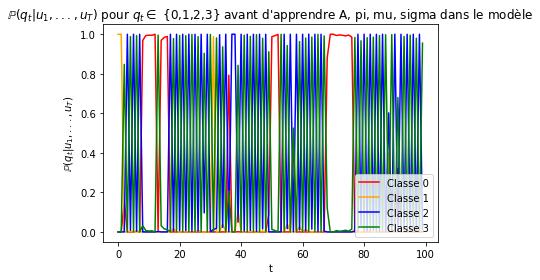

In [9]:
alphas, betas = alpha(xtest, pi, A, mu, sigma), beta(xtest, pi, A, mu, sigma)
probas = pqt(alphas, betas)

fig, ax = plt.subplots()
ax.plot(probas[0:100,0], label='Classe 0', color = "red")
ax.plot(probas[0:100,1], label='Classe 1', color = "orange")
ax.plot(probas[0:100,2], label='Classe 2', color = "blue")
ax.plot(probas[0:100,3], label='Classe 3', color = "green")
ax.legend(loc="lower right")
ax.set_title("$\mathbb{P}(q_{t}|u_{1},...,u_{T})$ pour $q_{t} \in$ {0,1,2,3} avant d'apprendre A, pi, mu, sigma dans le modèle")
ax.set_xlabel("t")
ax.set_ylabel("$\mathbb{P}(q_{t}|u_{1},...,u_{T})$")
plt.show()
plt.close()

### Question 4

In [10]:
def EM_HMM(x, x2):
    #On renvoie les paramètres appris sur l'échantillon train ainsi que les historiques des log-vraisemblances pour les échantillons train et test selon les itérations
    #On redéfinit mu, sigma, A, et pi pour garder nos initialisations
    
    pi = 1/k*np.ones(k)
    A = 1/6*np.ones((k,k)) + 1/3*np.eye(k)
    mu, sigma = EM(x)
    
    n, p = x.shape
    
    al = alpha(x, pi, A, mu, sigma)
    be = beta(x, pi, A, mu, sigma)
    
    al2 = alpha(x2, pi, A, mu, sigma)
    be2 = beta(x2, pi, A, mu, sigma)
    
    p = pqt(al, be)
    p2 = pqt2(x, al, be, A, mu, sigma)
    
    #On calculera la log-vraissemblance à chaque itération
    v1 = loglkd_HMM(al, be)
    vrais = [v1]
    vrais2 = [loglkd_HMM(al2, be2)]
    v2=0

    while abs(v1-v2) > 1e-1: #On s'arrête quand la vraissemblance n'évolue plus assez
        
        v2 = v1
        
        pi = p[0] #Mise à jour de pi 
        
        A = np.sum(p2, axis=0)/np.sum(np.sum(p2, axis=2), axis=0) #Mise à jour de A
        
        for j in range(k):
            mu[j] = np.sum(np.dot(x.transpose(), np.diag(p[:, j])), axis=1)/np.sum(p[:, j]) #Mise à jour de mu
            x_mu = x - mu[j]
            sigma[j] = np.dot(np.dot(x_mu.transpose(), np.diag(p[:, j])), x_mu)/np.sum(p[:, j]) #Mise à jour de sigma
        
        al = alpha(x, pi, A, mu, sigma)
        be = beta(x, pi, A, mu, sigma)
        
        al2 = alpha(x2, pi, A, mu, sigma)
        be2 = beta(x2, pi, A, mu, sigma)
    
        p = pqt(al, be)
        p2 = pqt2(x, al, be, A, mu, sigma)

        v1 = loglkd_HMM(al, be)
        vrais.append(v1)
        vrais2.append(loglkd_HMM(al2, be2))
    
    return pi, A, mu, sigma, vrais, vrais2

### Question 5:

In [11]:
pi, A, mu, sigma, vrais, vrais2 = EM_HMM(x, xtest)

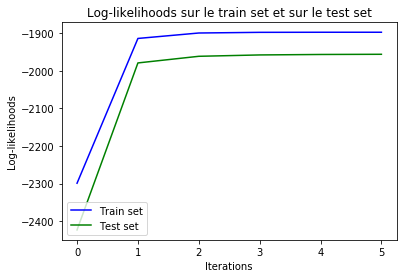

In [12]:
fig2, axlikelihoods = plt.subplots()
axlikelihoods.plot(vrais, label='Train set', color = "blue")
axlikelihoods.plot(vrais2, label='Test set', color = "green")
axlikelihoods.legend(loc="lower left")
axlikelihoods.set_title("Log-likelihoods sur le train set et sur le test set")
axlikelihoods.set_xlabel("Iterations")
axlikelihoods.set_ylabel("Log-likelihoods")
plt.show()
plt.close()

### Question 6:

In [13]:
def vraissemblanceGM(x):
    return np.sum(np.log(np.dot(pi,\
                             np.array([sct.multivariate_normal.pdf(x, mu[j], sigma[j]) for j in range(k)]))))
vraissemblances = np.array([[vrais[-1], vraissemblanceGM(x)], [vrais2[-1], vraissemblanceGM(xtest)]])

In [14]:
print("Le tableau des vraissemblances des modèles Gaussian Mixture et HMM est:")
print(vraissemblances)
print("Sur la première ligne, on a les vraissemblances du train set et sur la deuxième ligne celles du test set.")
print("Sur la première colonne, on a les vraissemblances sur le modèle HMM et sur la deuxième colonnes celles du modèle Gaussian Mixture")

Le tableau des vraissemblances des modèles Gaussian Mixture et HMM est:
[[-1896.7940321  -8463.20897022]
 [-1955.54595267 -9505.52634172]]
Sur la première ligne, on a les vraissemblances du train set et sur la deuxième ligne celles du test set.
Sur la première colonne, on a les vraissemblances sur le modèle HMM et sur la deuxième colonnes celles du modèle Gaussian Mixture


In [15]:
indices = np.arange(500)
np.random.shuffle(indices)

Les valeurs de vraissemblances sont:
Pour le train:  -2324.84733385
Pour le test:  -2487.21867245


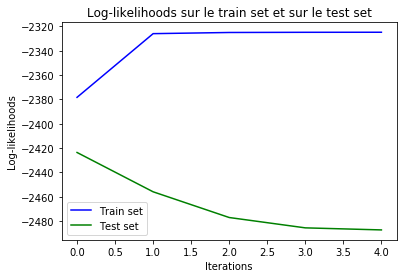

In [16]:
#Pour vérifier l'hypothèse de  temporalité des données, on peut effectuer certain tests:

#On mélange le train et pas le test:
xs = x[indices]
pi, A, mu, sigma, vrais, vrais2 = EM_HMM(xs, xtest)

print("Les valeurs de vraissemblances sont:")

print("Pour le train: ", vrais[-1])
print("Pour le test: ", vrais2[-1])


fig2, axlikelihoods = plt.subplots()
axlikelihoods.plot(vrais, label='Train set', color = "blue")
axlikelihoods.plot(vrais2, label='Test set', color = "green")
axlikelihoods.legend(loc="lower left")
axlikelihoods.set_title("Log-likelihoods sur le train set et sur le test set")
axlikelihoods.set_xlabel("Iterations")
axlikelihoods.set_ylabel("Log-likelihoods")
plt.show()
plt.close()

Les valeurs de vraissemblances sont:
Pour le train set:  -2322.78496795
Pour le test set:  -2423.75913466


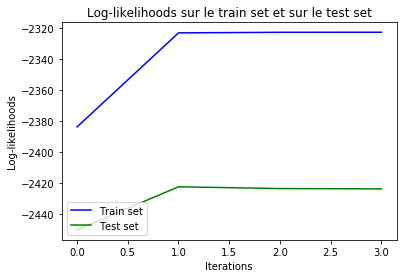

In [29]:
#On mélange le train et le test de la même manière:
np.random.shuffle(indices)
xs = x[indices]
xstest = xtest[indices]
pi, A, mu, sigma, vrais, vrais2 = EM_HMM(xs, xstest)

print("Les valeurs de vraissemblances sont:")

print("Pour le train set: ", vrais[-1])
print("Pour le test set: ", vrais2[-1])

fig2, axlikelihoods = plt.subplots()
axlikelihoods.plot(vrais, label='Train set', color = "blue")
axlikelihoods.plot(vrais2, label='Test set', color = "green")
axlikelihoods.legend(loc="lower left")
axlikelihoods.set_title("Log-likelihoods sur le train set et sur le test set")
axlikelihoods.set_xlabel("Iterations")
axlikelihoods.set_ylabel("Log-likelihoods")
plt.show()
plt.close()

In [20]:
pi, A, mu, sigma, vrais, vrais2 = EM_HMM(x, xtest) #On récupère les bonnes valeurs

### Question 8:

In [23]:
#Viterbi algorithm: on renvoie la séquence d'états la plus probable

def viterbi_alg(x, pi, A, mu, sigma, t=500):
    T = x.shape[0]
    argmax = np.zeros((T-1, k))
    v = np.ones(k)
    
    for j in range(k):
        e = sct.multivariate_normal.pdf(x[0], mu[j], sigma[j])
        if pi[j]!=0 and e!=0:
            v[j] = np.log(pi[j]) + np.log(e)
    
    for i in range(1, T):
        v2 = np.array(v)
        
        for j in range(k):
            cond = (A[j]!=0)*(v2!=1)
            a = np.log(A[j][cond])
            if len(a)!=0:
                v3 = v2[cond]
                argmax[i-1, j] = np.argmax(v3 + a)
            e = sct.multivariate_normal.pdf(x[i], mu[j], sigma[j])
            if e!=0 and len(a)!=0:
                v[j] = np.log(e) + np.amax(v3 + a)
            else:
                v[j] = 1
    
    z = np.ones(T, dtype=int)
    
    z[T-1] = np.argmax(v)
    
    
    for t in range(T-1)[::-1]:
        
        z[t] = argmax[t, z[t+1]]
    
    return z

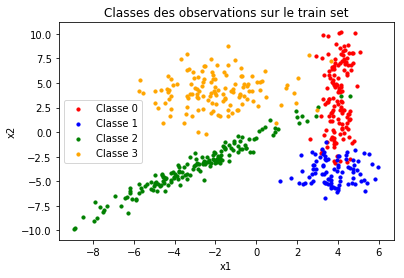

In [24]:
mostLikelySequence = viterbi_alg(x, pi, A, mu, sigma)


data0 = x[mostLikelySequence==0]
data1 = x[mostLikelySequence==1]
data2 = x[mostLikelySequence==2]
data3 = x[mostLikelySequence==3]

p0 = plt.scatter(data0[0:,0], data0[0:,1], color="red", s=10)
p1 = plt.scatter(data1[0:,0], data1[0:,1], color="blue", s=10)
p2 = plt.scatter(data2[0:,0], data2[0:,1], color="green", s=10)
p3 = plt.scatter(data3[0:,0], data3[0:,1], color="orange", s=10)

plt.legend((p0,p1,p2,p3), ("Classe 0", "Classe 1", "Classe 2", "Classe 3"))
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Classes des observations sur le train set')
plt.show()
plt.close()

### Question 9

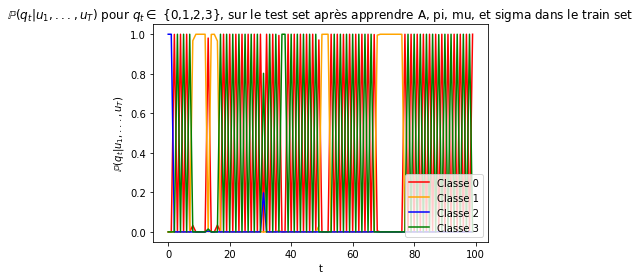

In [25]:
#pi, A, mu, sigma sont appris sur le train set (comme précédemment)
alphas, betas = alpha(xtest, pi, A, mu, sigma), beta(xtest, pi, A, mu, sigma)

probas = pqt(alphas, betas)

fig3, ax2 = plt.subplots()
ax2.plot(probas[0:100,0], label='Classe 0', color = "red")
ax2.plot(probas[0:100,1], label='Classe 1', color = "orange")
ax2.plot(probas[0:100,2], label='Classe 2', color = "blue")
ax2.plot(probas[0:100,3], label='Classe 3', color = "green")
ax2.legend(loc="lower right")
ax2.set_title("$\mathbb{P}(q_{t}|u_{1},...,u_{T})$ pour $q_{t} \in$ {0,1,2,3}, sur le test set après apprendre A, pi, mu, et sigma dans le train set")
ax2.set_xlabel("t")
ax2.set_ylabel("$\mathbb{P}(q_{t}|u_{1},...,u_{T})$")
plt.show()
plt.close()

### Question 10

In [26]:
mostLikelyClass = np.argmax(probas[:100], axis=1)

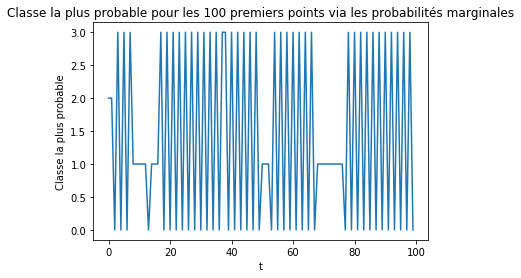

In [27]:
plt.plot(mostLikelyClass)
plt.title("Classe la plus probable pour les 100 premiers points via les probabilités marginales")
plt.xlabel("t")
plt.ylabel("Classe la plus probable")
plt.show()
plt.close()

### Question 11

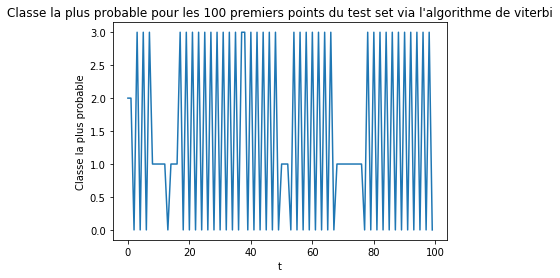

In [28]:
mostLikelySequence = viterbi_alg(xtest, pi, A, mu, sigma)

plt.plot(mostLikelySequence[0:100])
plt.title("Classe la plus probable pour les 100 premiers points du test set via l'algorithme de viterbi")
plt.xlabel("t")
plt.ylabel("Classe la plus probable")
plt.show()

plt.show()
plt.close()